In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 


In [0]:
!pip3 install torchvision

In [0]:
import torch
import torchvision
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import matplotlib.pyplot as plt 
import numpy as np
import os, time
import copy

In [0]:
transform =torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),torchvision.transforms.ToTensor()])

In [0]:
train_set = torchvision.datasets.CIFAR10(root = './data', train =True, download = True, transform =transform)

Files already downloaded and verified


In [0]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=32, shuffle = True)

In [0]:
test_set = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform=transform)

Files already downloaded and verified


In [0]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle=True)

In [0]:
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']


 6
 4
 0
 1
 5
 9
 7
 5
 3
 5
 4
 8
 7
 6
 0
 8
 4
 7
 3
 3
 3
 3
 3
 7
 0
 3
 7
 7
 4
 1
 9
 4
[torch.LongTensor of size 32]



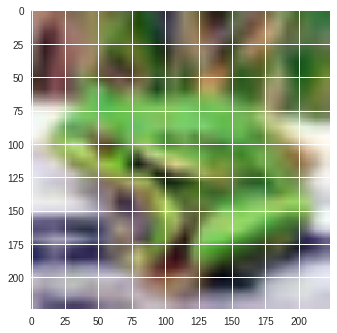

In [0]:
img, label = next(iter(train_loader))
plt.imshow(img[0].permute(1,2,0))
print(label)

In [0]:
vgg16 = models.vgg16_bn()
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (14): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (16): ReLU(inplace)
   

In [0]:
for param in vgg16.features.parameters():
    param.require_grad = False
num_features = vgg16.classifier[6].in_features
print(num_features)
features = list(vgg16.classifier.children())[:-1]
num_classes=10

4096


In [0]:
features.extend(([nn.Linear(num_features, num_classes)]))
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (14): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (16): ReLU(inplace)
   

In [0]:
plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [0]:
if use_gpu:
    vgg16.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)

In [0]:
def eval_model(vgg16, criterion):
    since = time.time()
    test_loss = 0
    test_acc = 0
    
    
    print("evaluating model")
    print("-"*10)
    
    for i, data in enumerate(test_loader):
        vgg16.train(False)
        vgg16.eval()
        inputs, label = data
        dataset_sizes = len(test_set)
        
        if use_gpu:
            inputs, label = Variable(inputs.cuda(), volatile=True), Variable(label.cuda(), volatile=True)
        else:
            inputs, label = Variable(inputs, volatile =True), Variable(label, volatile=True)
        
        outputs=vgg16(inputs)
        
        _ , preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, label)
        test_loss += loss.data[0]
        test_acc += torch.sum(preds==label.data)
        
        del inputs, label, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = test_loss / dataset_sizes
    avg_acc = test_acc / dataset_sizes
        
    elapsed_time = time.time()-since
    print("test_loss {:.4f}".format(avg_loss))
    print("test_acc {:.4f}".format(avg_acc))

In [0]:
model = eval_model(vgg16, criterion) 

evaluating model
----------
test_loss 0.0721
test_acc 0.1020


In [0]:
img, label = next(iter(test_loader))

In [0]:
def train_model(vgg16, criterion, optimizer, no_of_epochs=5):
    since =time.time()
    best_model_wts = copy.deepcopy(vgg16.state_dict())
    best_acc = 0
    
    avg_loss = 0 
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    
    train_batches = len(train_loader)
    valid_batches = len(test_loader)
    test_batches = len(test_loader)
    
    vgg16.train(True)
    
    for i, data in enumerate(train_loader):
        if(i % 100 == 0):
            print("\r Training batch {}/{}".format(i, train_batches/2), end ='', flush = True)
            
            loss_train = 0
            loss_val = 0
            acc_train = 0
            acc_val = 0
            #half training data 
            if i>= train_batches/2:
                break
                
            inputs, labels = data
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            outputs=vgg16(inputs)
            
            _ , preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data[0]
            acc_train += torch.sum(preds == labels.data)
            
            avg_loss = avg_loss*2/train_batches
            avg_acc = avg_acc*2/train_batches
            
            vgg16.train(False)
            vgg16.eval()
            
            for i, data in enumerate(test_loader):
                if(i % 100 == 0):
                    print("validation batch {}/{}".format(i, valid_batches), end = '', flush=True)
                
                inputs, labels = data
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                
                optimizer.zero_grad()
                
                outputs = vgg16(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                loss_val +=loss.data[0]
                acc_val +=torch.sum(preds==labels.data)
                
                avg_loss_val = loss_val /valid_batches
                avg_acc_val = acc_val / valid_batches
                
                print()
                print("Epoch {} result".format(epoch))
                print("train loss: {:.4f}".format(avg_loss))
                print("train acc: {:.4f}".format(avg_acc))
                print("valid loss: {:.4f}".format(avg_loss_val))
                print("valid acc: {:.4f}".format(avg_acc_val))
                
                
                if(avg_loss_val >= best_acc):
                    best_acc = avg_loss_val
                    best_model_wts = copy.deepcopy(vgg16.state_dict())
                
                elapsed_time = time.time() - since
                
                print("Training completed in {:.0f} minutes, {:.0f} seconds".format(elapsed_time//60, elapsed_time%60))
                
                print("best acc: {:.4f}".format(best_acc))
                
                vgg16.load_state_dict(best_model_wts)
                return vgg16
    

In [0]:
train_model(vgg16, criterion, optimizer, no_of_epochs=5)